## SVM Model


In [ ]:
%load_ext autoreload
%autoreload 2
from load_data import DataLoader
import flares_plot as fplt
from threshold import get_labels_physic

In [ ]:
# initialize data loader
data_loader = DataLoader()
# get the grid
grid = data_loader.get_grid()
# get params dictionary
params = data_loader.get_params()

params

{'run': 30,
 'sigma': [0.3, 0.4, 0.5, 0.6],
 'theta': [0.01, 0.1, 0.5, 3],
 'mu': [0.8, 0.9, 1, 1.1],
 'delta': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
 'N': 1000}

In [ ]:
print(grid.shape)

(30, 4, 4, 4, 10, 1000)


In [ ]:
run, mu, sigma, theta, delta = 0, 1, 0.5, 3, 0.2

In [ ]:
# get labels following physics method
physic_labels = get_labels_physic(grid, params, alpha=2)


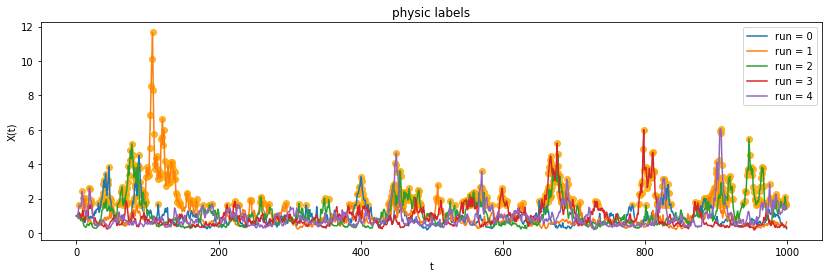

In [ ]:
run, mu, sigma, theta, delta = 1, 1, 0.3, 0.1, 0.5
# focuses on specific runs
#fplt.plot_grid_datapoints(grid, params, run=run, mu=mu, sigma=sigma, theta=theta, delta=delta, labels=labels)
# focuses on a set of runs
fplt.plot_grid_datapoints(grid, params, mu=mu, sigma=sigma, theta=theta, delta=delta,
                          num_run=5, variation='run', labels=physic_labels, title='physic labels')

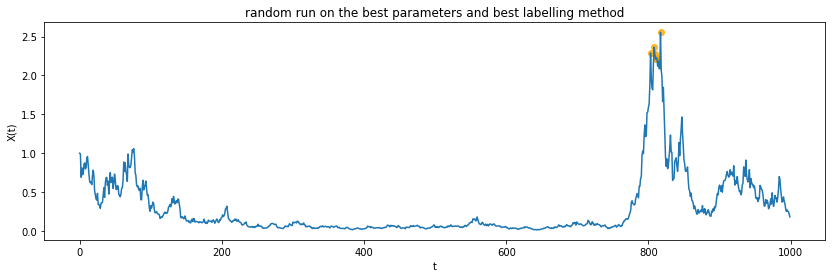

In [ ]:
# # extract the standard values
run = 6
labels_best = physic_labels
# labels_best = kde_labels
# labels_best = quantile_labels
bindexes = data_loader.get_standard_indexes()
X_best = data_loader.get_standard_values(run=run)
best_labels = labels_best[run, bindexes[0], bindexes[1], bindexes[2], bindexes[3], :]

# # plot one single light curve
fplt.plot_serie(X_best, labels=best_labels, title='random run on the best parameters and best labelling method')

## Dataframe Building

In [ ]:
import numpy as np
import pandas as pd

best_Xs = grid[:, bindexes[0], bindexes[1], bindexes[2], bindexes[3], :]
best_labels = labels_best[:, bindexes[0], bindexes[1], bindexes[2], bindexes[3], :]

window_size = 10
overlap_size = 0
label_treshold = 1
stride = window_size - overlap_size
num_windows = (best_Xs.shape[-1]-window_size)//stride + 1

windows = np.zeros((best_Xs.shape[0]*(num_windows-1),window_size))
windows_label = np.zeros((best_labels.shape[0]*(num_windows-1),window_size), dtype='bool')


for i in range(best_Xs.shape[0]):
    tmp_windows = np.array([best_Xs[i,j:j+window_size] for j in range(0,stride*num_windows,stride)])
    tmp_windows_labels = np.array([best_labels[i,j:j+window_size] for j in range(0,stride*num_windows,stride)])
    windows[i*(num_windows-1):(i+1)*(num_windows-1)] = tmp_windows[:-1,:]
    windows_label[i*(num_windows-1):(i+1)*(num_windows-1)] = tmp_windows_labels[1:,:]

windows_label = np.sum(windows_label, axis=-1)
windows_label[windows_label<label_treshold] = 0
windows_label[windows_label>=label_treshold] = 1

windows_df = pd.DataFrame(windows, columns=[f't_{i}' for i in range(windows.shape[-1])])
label_df = pd.DataFrame({'future_flare':windows_label})
labelled_windows_df = pd.concat([windows_df, label_df], axis=1)

labelled_windows_df



,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,future_flare
0,1.000000,0.987600,0.785896,0.841577,0.832249,0.782339,1.098576,1.034369,1.065688,1.396328,0
1,1.344950,1.361417,1.454124,1.481221,1.739084,1.824354,1.865991,1.748245,2.016654,1.962600,0
2,2.136767,1.900910,1.842975,1.392468,0.936490,1.009156,1.114423,1.093375,1.016034,1.035544,0
3,1.111971,1.152431,0.897187,0.842220,1.124429,1.031089,1.097192,1.374208,1.586394,1.373240,0
4,1.148019,1.039919,1.102339,1.152287,1.061448,0.908979,0.846604,0.678237,0.596491,0.666381,0
...,...,...,...,...,...,...,...,...,...,...,...
2965,0.087812,0.062624,0.065280,0.052309,0.048366,0.055236,0.058978,0.063442,0.058054,0.055112,0
2966,0.057390,0.063970,0.063839,0.053189,0.038101,0.037498,0.047341,0.045256,0.053053,0.052463,0
2967,0.056596,0.056859,0.059152,0.059293,0.060328,0.054363,0.052793,0.051796,0.059634,0.063387,0
2968,0.065167,0.055373,0.063792,0.072816,0.072152,0.065053,0.057493,0.055421,0.058620,0.050251,0


In [ ]:
labelled_windows_df['future_flare'].value_counts()

0    2782
1     188
Name: future_flare, dtype: int64

In [ ]:
#Undersampling classe più presente
#labelled_windows_df = labelled_windows_df[(labelled_windows_df['future_flare'] != 0) | (labelled_windows_df.index >= 2000)]

#Provare aumentando weight classe 1 rispetto a balanced

In [ ]:
labelled_windows_df['future_flare'].value_counts()

0    2782
1     188
Name: future_flare, dtype: int64

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

test_size = 0.3
random_state = 42

X = labelled_windows_df.iloc[:,:-1].to_numpy()
y = labelled_windows_df.future_flare.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
class_weights = {0: 1, 1: 5}
#svm_model = SVC(class_weight='balanced', probability=True)
svm_model = SVC(class_weight= class_weights, probability=True)
#svm_model = SVC(probability=True)
#svm_model = SVC()
svm_model.fit(X_train, y_train)
print(svm_model.predict_proba(X_test))
y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)
# print(f1_score(y_test,y_pred))
# print(accuracy_score(y_test, y_pred))

#print(classification_report(y_train, y_pred_train))
#print(classification_report(y_test, y_pred_test))

#print(confusion_matrix(y_test, y_pred_test))

[[9.99630096e-01 3.69904102e-04]
 [9.89619101e-01 1.03808988e-02]
 [9.99637683e-01 3.62317091e-04]
 ...
 [9.99658646e-01 3.41354203e-04]
 [9.99583017e-01 4.16983350e-04]
 [9.99590497e-01 4.09502764e-04]]


In [ ]:
print(svm_model.class_weight)

{0: 1, 1: 5}


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       835
           1       0.86      0.89      0.88        56

    accuracy                           0.98       891
   macro avg       0.93      0.94      0.93       891
weighted avg       0.98      0.98      0.98       891



In [ ]:
print(svm_model.predict(X_test))

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 

In [ ]:
print(confusion_matrix(y_test, y_pred_test))

[[814  21]
 [  3  53]]
